# Bachelor Thesis
## MNIST classification using persistent homology

### Installs/Imports

In [2]:
#!pip install giotto-tda
!pip install catboost
!pip install lightgbm
!pip install xgboost

distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |████▏                           | 9.0 MB 5.3 MB/s eta 0:00:12^C             | 1.9 MB 1.6 MB/s eta 0:00:42

ERROR: Operation cancelled by user
distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 2.0 MB 1.5 MB/s eta 0:00:01
^C
ERROR: Operation cancelled by user
distutils: /home/snopoff/miniconda3/envs/topology/include/python3.9/UNKNOWN
sysconfig: /home/snopoff/miniconda3/envs/topology/include/python3.9
user = False
home = None
root = None
prefix = None
     |▍                               | 2.1 MB 1.5 MB/s eta 0:01:52^C

ERROR: Operation cancelled by user


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly as pl
from plotly.subplots import make_subplots
from sklearn import datasets
from IPython.display import HTML

from sklearn.model_selection import train_test_split

from gtda.homology import CubicalPersistence
from gtda.images import Binarizer, RadialFiltration, DensityFiltration
from gtda.diagrams import Scaler

from gtda.diagrams import HeatKernel

from sklearn.pipeline import make_pipeline, make_union, Pipeline
from gtda.diagrams import PersistenceEntropy, Amplitude
from gtda.images import HeightFiltration
from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from scipy.stats import pearsonr

### 1. Load MNIST Data and create train/test datasets

Let's load MNIST data

In [4]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [5]:
y = y.to_numpy()
X = X.to_numpy().reshape((-1, 28, 28))

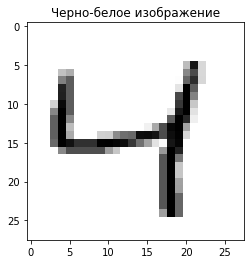

In [ ]:
plt.imshow(X[2], cmap='gray_r')
plt.title("Черно-белое изображение")
plt.show()

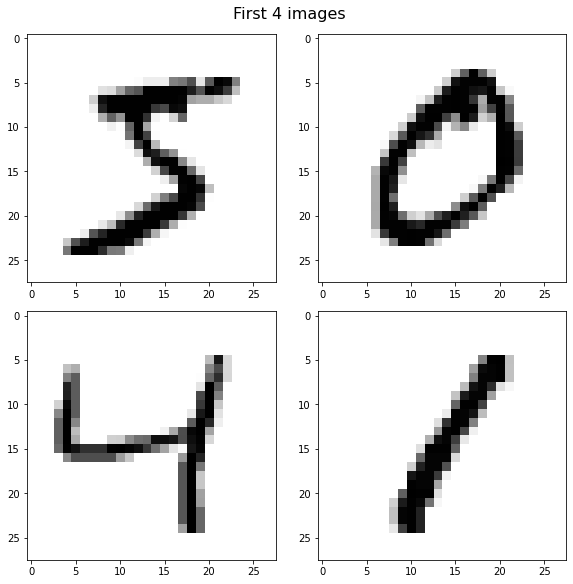

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X[i], cmap='gray_r')
fig.suptitle("First 4 images", fontsize = 16)
plt.show()

In [6]:
train_size, test_size = 700, 300


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, random_state = 42, shuffle = True)

In [ ]:
y_train.shape

(700,)

### 2. Create cubical complexes from data and extract topological features

#### 2.1 Binarization

In [ ]:
binarizer = Binarizer(threshold=0.4)

In [ ]:
X_bin = binarizer.fit_transform(X).reshape((-1, 28, 28))

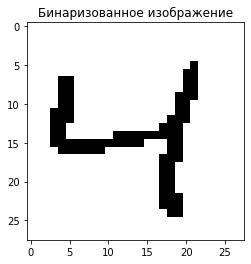

In [ ]:
plt.imshow(X_bin[2], cmap='gray_r')
plt.title("Бинаризованное изображение")
plt.show()

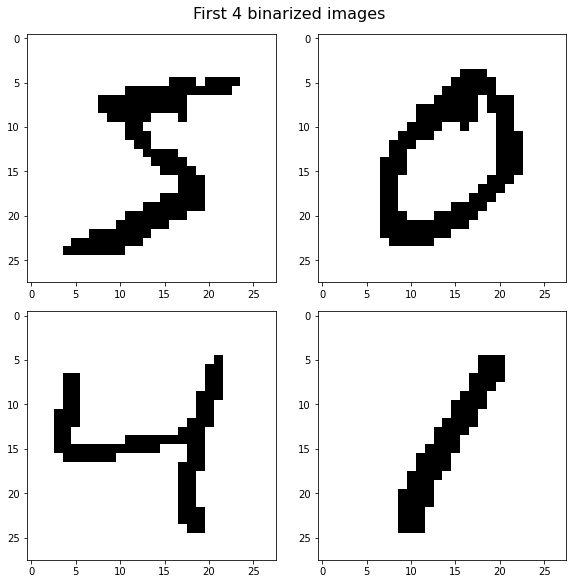

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_bin[i], cmap = 'gray_r')
fig.suptitle("First 4 binarized images", fontsize = 16)
plt.show()

#### 2.2 Filtration

In [ ]:
radial_filtration = RadialFiltration(center=np.array([20, 6]))
height_filtration = HeightFiltration(direction=np.array([1,0]))
density_filtration = DensityFiltration(radius=5)

rad = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
height = height_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
dens = density_filtration.fit_transform(X_bin).reshape((-1, 28, 28))
img = X[2]

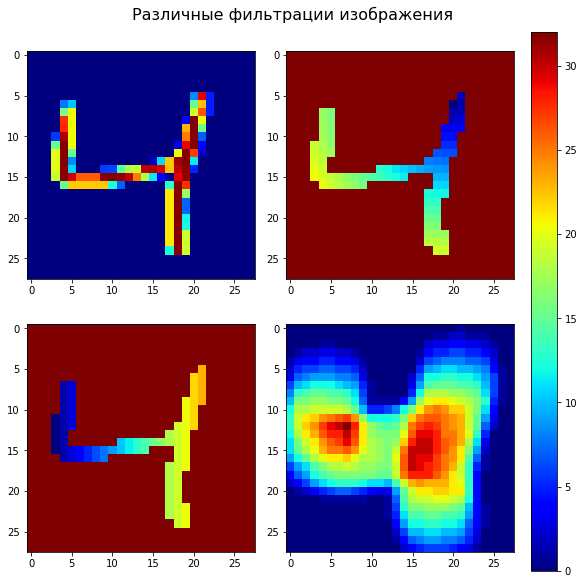

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
axes[0][0].imshow(img, cmap='jet')
axes[0][1].imshow(rad[2], cmap='jet')
axes[1][0].imshow(height[2], cmap='jet')
im = axes[1][1].imshow(dens[2], cmap='jet')

fig.suptitle("Различные фильтрации изображения", fontsize = 16)
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

In [ ]:
X_filt = radial_filtration.fit_transform(X_bin).reshape((-1, 28, 28))

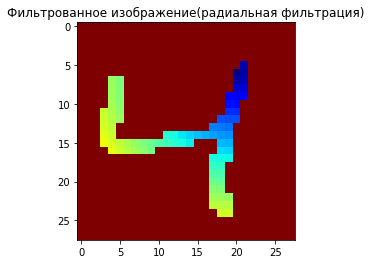

In [ ]:
plt.imshow(X_filt[2], cmap='jet')
plt.title("Фильтрованное изображение(радиальная фильтрация)")
plt.show()

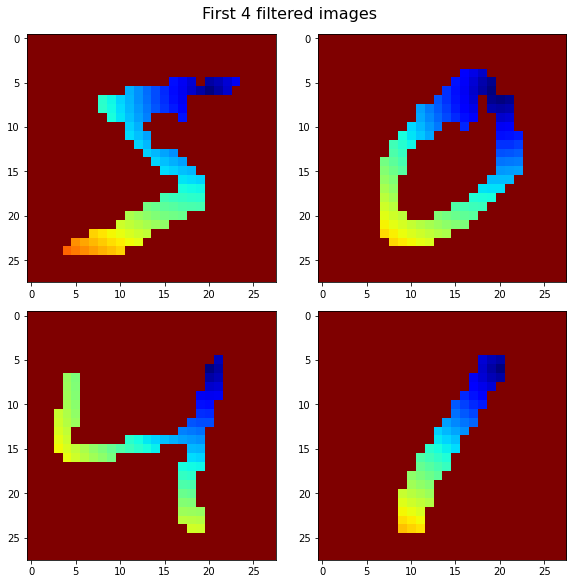

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ax.imshow(X_filt[i], cmap = "jet")
fig.suptitle("First 4 filtered images", fontsize = 16)
plt.show()

#### 2.3 Persistence

In [ ]:
cubical_persistence = CubicalPersistence(n_jobs=-1)

In [ ]:
X_rad = cubical_persistence.fit_transform(rad)
X_height = cubical_persistence.fit_transform(height)
X_dens = cubical_persistence.fit_transform(dens)

In [ ]:
cubical_persistence.plot(X_rad)

In [ ]:
cubical_persistence.plot(X_height)

In [ ]:
cubical_persistence.plot(X_dens)

In [ ]:
X_pers = cubical_persistence.fit_transform(X_filt)

In [ ]:
cubical_persistence.plot(X_pers[2][None, :, :])

#### 2.4 Scaling

In [ ]:
scaler = Scaler()

In [ ]:
X_rad_scale = scaler.fit_transform(X_rad)
X_height_scale = scaler.fit_transform(X_height)
X_dens_scale = scaler.fit_transform(X_dens)

In [ ]:
scaler.plot(X_height_scale)

In [ ]:
scaler.plot(X_rad_scale)

In [ ]:
scaler.plot(X_dens_scale)

In [ ]:
X_scale = scaler.fit_transform(X_pers)

In [ ]:
scaler.plot(X_scale[0][None, :, :])

### 3. Vector representation

In [ ]:
heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)

In [ ]:
X_heat = heat.fit_transform(X_scale)

In [ ]:
heat.fit_transform_plot(X_rad_scale,colorscale='jet')

array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 7.34794600e-05,  7.73586555e-05,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.83242486e-05,  0.00000000e+00, -7.73586555e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.83242486e-05, -7.34794600e-05, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e

In [ ]:
heat.fit_transform_plot(X_dens_scale,colorscale='jet')

array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.97530156,  0.48757006,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.50564106,  0.        , -0.48757006, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -0.50564106, -0.97530156, ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        

In [ ]:
heat.fit_transform_plot(X_height_scale, colorscale='jet')

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])

In [ ]:
heat.plot(X_heat[2][None, :, :], homology_dimension_idx=0, colorscale='jet')

### 4. Creating pipeline

In [7]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

radius_list = [2, 4, 6]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    + [DensityFiltration(radius=r) for r in radius_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
]


feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-11',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 1,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-12',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 1.6},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-13',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.2},
                                                                                           n_jobs=-1))]))]))])

In [9]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 560)

### 5. Classification

Random Forest Classifier:

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

acc_rf = rf.score(X_train_tda, y_train)
score_rf = rf.score(X_test_tda, y_test)

Logistic Regression:

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tda, y_train)

acc_lr = lr.score(X_train_tda, y_train)
score_lr = lr.score(X_test_tda, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Support Vector Machine Classifier:

In [ ]:
svc = SVC(kernel='linear')
svc.fit(X_train_tda, y_train)

acc_svc = svc.score(X_train_tda, y_train)
score_svc = svc.score(X_test_tda, y_test)

In [ ]:
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

LightGBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_tda, y_train)

acc_lgbm = lgbm.score(X_train_tda, y_train)
score_lgbm = lgbm.score(X_test_tda, y_test)

CatBoost

In [ ]:
cat = CatBoostClassifier()#task_type="GPU", devices='0:1')
cat.fit(X_train_tda, y_train, verbose=False)

acc_cat = cat.score(X_train_tda, y_train)
score_cat = cat.score(X_test_tda, y_test)

XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_tda, y_train)

acc_xgb = xgb.score(X_train_tda, y_train)
score_xgb = xgb.score(X_test_tda, y_test)

In [ ]:
print("RF:\t", acc_rf, "\t", score_rf)
print("LR:\t", acc_lr, "\t", score_lr)
print("SVC:\t", acc_svc, "\t", score_svc)
print("LGBM:\t", acc_lgbm, "\t", score_lgbm)
print("CatBoost:", acc_cat, "\t", score_cat)
print("xgb:\t", acc_xgb, "\t", score_xgb)

RF:	 1.0 	 0.89
LR:	 0.9885714285714285 	 0.9033333333333333
SVC:	 1.0 	 0.8933333333333333
LGBM:	 1.0 	 0.9
CatBoost: 1.0 	 0.8933333333333333
xgb:	 1.0 	 0.8833333333333333


### 6. Tuning

#### 6.1 Feature Selection

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

print(rf.score(X_test_tda, y_test))

len(rf.feature_importances_)
#bestFeatures = rf.feature_importances_.argsort()[-250:][::-1]
#X_train_best = X_train_tda[:, bestFeatures]

0.89


644

In [ ]:
bestFeatures = rf.feature_importances_.argsort()[-200:][::-1]
X_train_best = X_train_tda[:, bestFeatures]
X_test_best = X_test_tda[:, bestFeatures]

#### 6.2 Tuning models

##### 6.2.1 Random Forest __(0.8842913563943607 for 200 features & 0.8742831639827348 for 250)__

In [ ]:
# rf_pipeline = Pipeline([
#     ('features', tda_union),
#     ('classifier', RandomForestClassifier(random_state=42))
# ])

# threshold_list = [0.1, 0.4, 0.7, 0.9]
# direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]
# n_estimators_list = [500, 1000, 2000]

# param_grid = {
#     #"filtration__direction": [np.array(direction) for direction in direction_list],
#     "classifier__n_estimators": [n_estimators for n_estimators in n_estimators_list],
#     'classifier__max_depth': [80, 90, 100],
#     'classifier__max_features': [2, 3, 4],
#     #'classifier__min_samples_leaf': [3, 4, 5],
#     #'classifier__min_samples_split': [8, 10, 12],
#     'classifier__n_estimators': [100, 200, 300, 1000]
# }

# grid_search = GridSearchCV(
#     estimator=rf_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2
# )

# grid_search.fit(X_train, y_train)

rf_params = {
    "n_estimators": [500, 1000, 2000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

rf_grid.fit(X_train_tda, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [80, 90, 100], 'max_features': [2, 3, 4],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=4)

In [ ]:
rf_bestacc = rf_grid.best_score_
rf_bestscore = rf_grid.score(X_test_tda, y_test)

In [ ]:
rf_grid.best_params_

{'max_depth': 80,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

##### 6.2.2 Support Vector Machine __(0.901409828448455 for 200 features & 0.9113996796400231 for 250)__

In [ ]:
svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

svm = SVC(random_state=42)

svm_grid = GridSearchCV(
    estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
)

svm_grid.fit(X_train_tda, y_train)

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'coef0': [1.0, 0.0625, 0.012345679012345678, 1.0,
                                   0.125, 0.037037037037037035, 1.0, 0.25,
                                   0.1111111111111111, 1.0, 0.5,
                                   0.3333333333333333, 1.0, 1.0, 1.0],
                         'decision_function_shape': ('ovr', 'ovo'),
                         'degree': [3, 5, 7], 'gamma': ('scale', 'auto'),
                         'kernel': ('linear', 'sigmoid', 'rbf', 'poly')},
             verbose=4)

In [ ]:
svm_bestacc = svm_grid.best_score_
svm_bestscore = svm_grid.score(X_test_tda, y_test)

In [ ]:
svm_grid.best_params_

{'C': 100,
 'coef0': 0.25,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'poly'}

##### 6.2.3 Logistic Regression __(0.9028526710930146 for 200 features & 0.9099874056955602 for 250)__

In [ ]:
log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

log = LogisticRegression()

log_grid = GridSearchCV(
    estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
)

log_grid.fit(X_train_tda, y_train)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10426984 0.59712899
 0.59569837 0.52424098 0.59712899 0.59283103        nan        nan
        nan        nan        nan        nan        nan 0.11857599
        nan 0.11714537 0.80429307 0.80286857 0.80287468 0.81000942
 0.81000942        nan        nan        nan        nan        nan
        nan        nan 0.77428683        nan 0.79142976 0.88575865
 0.88575865 0.88003619 0.88718927 0.88718316        nan        nan
        nan        nan        nan        nan        nan 0.89715467
        nan 0.87574435 0.89288116 0.89716078 0.90717509 0.89716078
 0.89431178        nan        nan        nan        nan        nan
        nan        nan 0.91143025        nan 0.89431789 0.894324
 0.89288727 0.90431997 0.89574239 0.89430566        nan        nan
        nan        nan        nan        nan        nan 0.9

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', 'lasso'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=4)

In [ ]:
log_bestacc = log_grid.best_score_
log_bestscore = log_grid.score(X_test_tda, y_test)

In [ ]:
log_grid.best_params_

{'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}

##### 6.2.4 CatBoost __(0.89 for both)__

In [ ]:
cat = CatBoostClassifier(task_type="GPU", devices='0:1');

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

grid_search_result = cat.grid_search(grid, 
                                       X=X_train_tda, 
                                       y=y_train, 
                                       plot=True)

In [ ]:
bestCat = CatBoostClassifier(**grid_search_result['params'], task_type="GPU",
                           devices='0:1')
bestCat.fit(X_train_tda, y_train)

cat_bestacc = bestCat.score(X_train_tda, y_train)

0:	learn: 2.1479323	total: 34.3ms	remaining: 34.3s
1:	learn: 2.0111019	total: 65.1ms	remaining: 32.5s
2:	learn: 1.9072065	total: 92.7ms	remaining: 30.8s
3:	learn: 1.8084309	total: 120ms	remaining: 29.9s
4:	learn: 1.7247342	total: 154ms	remaining: 30.7s
5:	learn: 1.6466289	total: 182ms	remaining: 30.1s
6:	learn: 1.5734136	total: 208ms	remaining: 29.6s
7:	learn: 1.5189415	total: 241ms	remaining: 29.9s
8:	learn: 1.4623590	total: 269ms	remaining: 29.6s
9:	learn: 1.4085245	total: 299ms	remaining: 29.6s
10:	learn: 1.3562864	total: 334ms	remaining: 30s
11:	learn: 1.3034546	total: 364ms	remaining: 30s
12:	learn: 1.2561895	total: 402ms	remaining: 30.5s
13:	learn: 1.2162988	total: 436ms	remaining: 30.7s
14:	learn: 1.1759807	total: 472ms	remaining: 31s
15:	learn: 1.1380824	total: 499ms	remaining: 30.7s
16:	learn: 1.1000987	total: 531ms	remaining: 30.7s
17:	learn: 1.0666719	total: 561ms	remaining: 30.6s
18:	learn: 1.0372696	total: 594ms	remaining: 30.7s
19:	learn: 1.0078162	total: 624ms	remaining:

In [ ]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 0.1, 'learning_rate': 0.03}

In [ ]:
cat_bestscore = bestCat.score(X_test_tda, y_test)

#### 6.2.5 XGBoost

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier()

xgb_gridsearch = GridSearchCV(
    estimator=xgb, param_grid=params, cv=3, n_jobs=-1, verbose=4
)
xgb_gridsearch.fit(X_train_tda, y_train)

xgb_bestacc = xgb_gridsearch.best_score
xgb_bestscore = xgb_gridsearch.best_model.score(X_test_tda, y_test)

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


#### 6.2.6 LightGBM

In [ ]:
param_grid = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [50, 100],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

lgbm = LGBMClassifier()
lgbm_gridsearch = GridSearchCV(
    estimator=lgbm, param_grid=params, cv=3, n_jobs=-1, verbose=4
)
lgbm_gridsearch.fit(X_train_tda, y_train)

lgbm_bestacc = lgbm_gridsearch.best_score
lgbm_bestscore = lgbm_gridsearch.best_model.score(X_test_tda, y_test)

In [ ]:
print("RF:\t", rf_bestacc, "\t", rf_bestscore)
print("LR:\t", log_bestacc, "\t", log_bestscore)
print("SVC:\t", svm_bestacc, "\t", svm_bestscore)
print("CatBoost:", cat_bestacc, "\t", cat_bestscore)

RF:	 0.8800056246408178 	 0.8733333333333333
LR:	 0.9114302483401197 	 0.9166666666666666
SVC:	 0.9028587848330338 	 0.8933333333333333
CatBoost: 1.0 	 0.8933333333333333


### 7. Accuracy via number of features

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)
sortedFeatures = rf.feature_importances_.argsort()

numOfFeatures = np.arange(50, len(sortedFeatures), 50)

In [ ]:
accuracies = []

rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

for num in numOfFeatures:
    print(num)
    bestFeatures = rf.feature_importances_.argsort()[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]
    svc_num = SVC(random_state=42)
    svc_num.fit(X_train_best, y_train)
    X_test_num = X_test_tda[:, bestFeatures]
    accuracies.append(svc_num.score(X_test_num, y_test))


50
100
150
200
250
300
350
400
450
500
550
600
612


In [ ]:
print(accuracies)

[0.8, 0.83, 0.7966666666666666, 0.8333333333333334, 0.8566666666666667, 0.8566666666666667, 0.8433333333333334, 0.8466666666666667, 0.8366666666666667, 0.84, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]


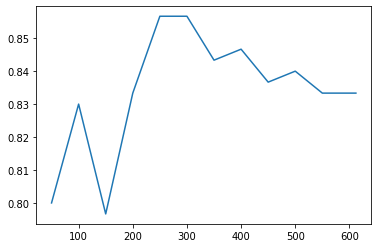

In [ ]:
plt.plot(numOfFeatures, accuracies)

In [ ]:
s = SVC(random_state=42)

X_train_part = X_train_tda[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.fit(X_train_part, y_train)

X_test_num = tda_union.transform(X_test)[:, rf.feature_importances_.argsort()[-50:][::-1]]
s.score(X_test_num, y_test)

0.8

### 8. Grid Search with different numbers of features

#### 8.1 Random Forest

In [11]:
params_rf = []
scores_rf = []
accuracies_rf = []

rf_params = {
    "n_estimators": [500, 1000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    rf = RandomForestClassifier(random_state=42)

    rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

    rf_grid.fit(X_train_best, y_train)

    params_rf.append(rf_grid.best_params_)
    scores_rf.append(rf_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_rf.append(rf_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 243 candidates, totalling 729 fits
100
Fitting 3 folds for each of 243 candidates, totalling 729 fits
150
Fitting 3 folds for each of 243 candidates, totalling 729 fits
200
Fitting 3 folds for each of 243 candidates, totalling 729 fits
250
Fitting 3 folds for each of 243 candidates, totalling 729 fits
300
Fitting 3 folds for each of 243 candidates, totalling 729 fits
350
Fitting 3 folds for each of 243 candidates, totalling 729 fits
400
Fitting 3 folds for each of 243 candidates, totalling 729 fits
450
Fitting 3 folds for each of 243 candidates, totalling 729 fits
500
Fitting 3 folds for each of 243 candidates, totalling 729 fits
550
Fitting 3 folds for each of 243 candidates, totalling 729 fits
FINISHED


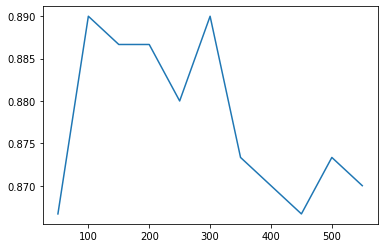

In [90]:
plt.plot(numOfFeatures, accuracies_rf)

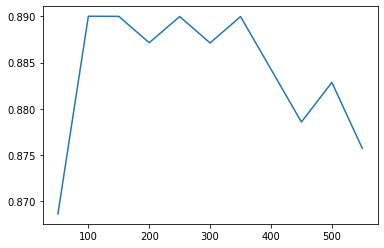

In [91]:
plt.plot(numOfFeatures, scores_rf)

#### 8.2 SVM

In [12]:
params_svm = []
scores_svm = []
accuracies_svm = []


svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params_svm.append(svm_grid.best_params_)
    scores_svm.append(svm_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_svm.append(svm_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
100
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
150
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
200
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
250
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
300
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
350
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
400
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
450
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
500
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
550
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
FINISHED


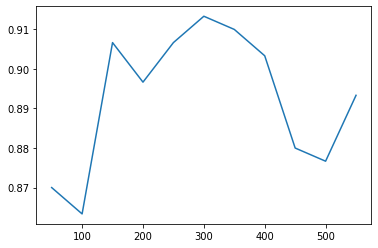

In [93]:
plt.plot(numOfFeatures, accuracies_svm)

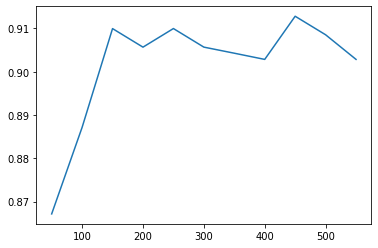

In [94]:
plt.plot(numOfFeatures, scores_svm)

#### 8.3 Logistic Regression

In [13]:
params_log = []
scores_log = []
accuracies_log = []


log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    log = LogisticRegression()

    log_grid = GridSearchCV(
        estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
    )

    log_grid.fit(X_train_best, y_train)

    params_log.append(log_grid.best_params_)
    scores_log.append(log_grid.best_score_)

    X_test_num = X_test_tda[:, bestFeatures]
    accuracies_log.append(log_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.11144737 0.23002947
 0.23002947 0.34716261 0.23002947 0.23002947        nan        nan
        nan        nan        nan        nan        nan 0.11714537
        nan 0.11714537 0.48146925 0.48146925 0.4114547  0.48146925
 0.48146925        nan        nan        nan        nan        nan
        nan        nan 0.64002299        nan 0.6544025  0.78145214
 0.78145214 0.7714684  0.78145214 0.78145214        nan        nan
        nan        nan        nan        nan        nan 0.8500055
        nan 0.83857281 0.83145642 0.83145642 0.83715442 0.83145642
 0.8300258         nan        nan        nan        nan        nan
        nan        nan 0.87285866        nan 0.84715039 0.85426067
 0.85426067 0.85857085 0.84999327 0.84429527        nan        nan
        nan        nan        

100
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10714941 0.40003424
 0.40003424 0.42428744 0.40003424 0.40003424        nan        nan
        nan        nan        nan        nan        nan 0.11714537
        nan 0.11428414 0.73861927 0.73861927 0.57145739 0.73861927
 0.73861927        nan        nan        nan        nan        nan
        nan        nan 0.70289669        nan 0.75147647 0.8357666
 0.8357666  0.83574826 0.8357666  0.8357666         nan        nan
        nan        nan        nan        nan        nan 0.88856486
        nan 0.87431373 0.88144235 0.88144235 0.88287297 0.88144847
 0.88002397        nan        nan        nan        nan        nan
        nan        nan 0.90142817        nan 0.88286685 0.89428732
 0.89428732 0.89998533 0.89000159 0.88286685        nan        nan
        nan        nan        

150
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.09999633 0.46854481
 0.46854481 0.41854053 0.46854481 0.46854481        nan        nan
        nan        nan        nan        nan        nan 0.16852524
        nan 0.11714537 0.7457051  0.7457051  0.59712899 0.7457051
 0.74427448        nan        nan        nan        nan        nan
        nan        nan 0.73146008        nan 0.75142144 0.85718303
 0.85718303 0.85429123 0.85718303 0.85575242        nan        nan
        nan        nan        nan        nan        nan 0.87996894
        nan 0.87716274 0.8914322  0.8914322  0.8885832  0.8900077
 0.88429747        nan        nan        nan        nan        nan
        nan        nan 0.89568125        nan 0.88286074 0.89711187
 0.89711187 0.90139149 0.89141998 0.88714647        nan        nan
        nan        nan        n

200
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.1099923  0.47996527
 0.47996527 0.39853637 0.47996527 0.47710404        nan        nan
        nan        nan        nan        nan        nan 0.16852524
        nan 0.11714537 0.75999902 0.75999902 0.68001296 0.75999902
 0.75570718        nan        nan        nan        nan        nan
        nan        nan 0.72571928        nan 0.75998679 0.86288715
 0.86288715 0.86574227 0.86146265 0.86146265        nan        nan
        nan        nan        nan        nan        nan 0.88427302
        nan 0.87715662 0.89000159 0.89000159 0.89856083 0.88857709
 0.88572809        nan        nan        nan        nan        nan
        nan        nan 0.8985486         nan 0.88572809 0.89713021
 0.89855471 0.90854456 0.89284448 0.88857709        nan        nan
        nan        nan       

250
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.11287187 0.50711639
 0.50711639 0.41138134 0.50711639 0.50711639        nan        nan
        nan        nan        nan        nan        nan 0.16852524
        nan 0.11714537 0.76716433 0.76716433 0.73141117 0.76716433
 0.77143783        nan        nan        nan        nan        nan
        nan        nan 0.72856217        nan 0.778542   0.86859127
 0.86859127 0.86145042 0.87001577 0.87144027        nan        nan
        nan        nan        nan        nan        nan 0.88857097
        nan 0.88001174 0.89284448 0.89141998 0.89142609 0.88856486
 0.88571586        nan        nan        nan        nan        nan
        nan        nan 0.89999144        nan 0.88856486 0.90712618
 0.90713229 0.9085629  0.89284448 0.88998936        nan        nan
        nan        nan       

300
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.11714537 0.52713889
 0.52713889 0.40855068 0.52713889 0.52713889        nan        nan
        nan        nan        nan        nan        nan 0.16852524
        nan 0.11714537 0.7771664  0.7771664  0.75140922 0.7771664
 0.77860313        nan        nan        nan        nan        nan
        nan        nan 0.74713571        nan 0.79427876 0.88287908
 0.88287908 0.87859335 0.87716274 0.87859335        nan        nan
        nan        nan        nan        nan        nan 0.89855471
        nan 0.88430358 0.90142817 0.90142817 0.90712618 0.90143428
 0.89857917        nan        nan        nan        nan        nan
        nan        nan 0.91141802        nan 0.89572405 0.90284656
 0.90570779 0.90998741 0.89857917 0.89429344        nan        nan
        nan        nan        

350
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10856168 0.54000831
 0.54000831 0.39853026 0.54000831 0.53858381        nan        nan
        nan        nan        nan        nan        nan 0.14003522
        nan 0.1099923  0.78144602 0.78144602 0.76142964 0.78143991
 0.78001541        nan        nan        nan        nan        nan
        nan        nan 0.75713168        nan 0.78856242 0.87574435
 0.87574435 0.87716885 0.87574435 0.87574435        nan        nan
        nan        nan        nan        nan        nan 0.89997921
        nan 0.88002397 0.89856694 0.89999144 0.90712618 0.89714244
 0.89714855        nan        nan        nan        nan        nan
        nan        nan 0.91427925        nan 0.89857917 0.89998533
 0.90285267 0.90998129 0.89285671 0.89857917        nan        nan
        nan        nan       

400
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10856168 0.55714513
 0.55714513 0.3985486  0.55714513 0.55714513        nan        nan
        nan        nan        nan        nan        nan 0.11714537
        nan 0.11714537 0.77717252 0.77717252 0.77288679 0.78145825
 0.78716848        nan        nan        nan        nan        nan
        nan        nan 0.7571867         nan 0.79855227 0.87718719
 0.87861169 0.87861781 0.87718719 0.87576269        nan        nan
        nan        nan        nan        nan        nan 0.89714244
        nan 0.87433207 0.89713021 0.89570571 0.9071384  0.8914322
 0.89430566        nan        nan        nan        nan        nan
        nan        nan 0.91283641        nan 0.89574239 0.89711798
 0.89140775 0.90712618 0.88571586 0.89573016        nan        nan
        nan        nan        

450
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.11428414 0.56569825
 0.56427375 0.43713241 0.56569825 0.56711664        nan        nan
        nan        nan        nan        nan        nan 0.11857599
        nan 0.11714537 0.79572772 0.79572772 0.78573175 0.7957216
 0.79429099        nan        nan        nan        nan        nan
        nan        nan 0.76001736        nan 0.79855838 0.88574031
 0.88574031 0.87290146 0.87575658 0.87575046        nan        nan
        nan        nan        nan        nan        nan 0.89429344
        nan 0.88429747 0.90570167 0.90570779 0.90856902 0.89428732
 0.89571794        nan        nan        nan        nan        nan
        nan        nan 0.90285267        nan 0.89857305 0.89426287
 0.89140775 0.9071384  0.89713632 0.89856694        nan        nan
        nan        nan        

500
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10570045 0.58713302
 0.58570852 0.47998362 0.58713302 0.58855141        nan        nan
        nan        nan        nan        nan        nan 0.11857599
        nan 0.11714537 0.80716041 0.80716041 0.80429918 0.80859103
 0.80859103        nan        nan        nan        nan        nan
        nan        nan 0.77286233        nan 0.78857464 0.89146277
 0.89146277 0.87431985 0.88860766 0.88718316        nan        nan
        nan        nan        nan        nan        nan 0.89716078
        nan 0.88430358 0.89718523 0.9000159  0.90288324 0.90144651
 0.90431385        nan        nan        nan        nan        nan
        nan        nan 0.89857305        nan 0.90145262 0.88431581
 0.88574031 0.90715063 0.89716078 0.89859139        nan        nan
        nan        nan       

550
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.10000245        nan 0.10000245 0.59427387
 0.59427387 0.51425724 0.59427387 0.58712691        nan        nan
        nan        nan        nan        nan        nan 0.11857599
        nan 0.11714537 0.80572368 0.80572368 0.80286857 0.8085788
 0.81286453        nan        nan        nan        nan        nan
        nan        nan 0.77285622        nan 0.78857464 0.88861988
 0.88861988 0.88146681 0.89004439 0.88861988        nan        nan
        nan        nan        nan        nan        nan 0.89431178
        nan 0.87290146 0.89145055 0.89431789 0.90146485 0.89716689
 0.89431178        nan        nan        nan        nan        nan
        nan        nan 0.90000978        nan 0.89574239 0.89002604
 0.89144443 0.90430774 0.89289339 0.89574239        nan        nan
        nan        nan        

FINISHED


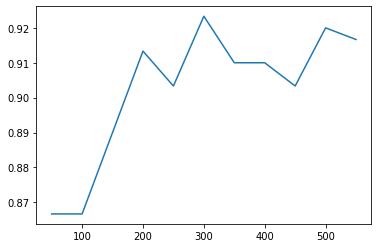

In [96]:
plt.plot(numOfFeatures, accuracies_log)

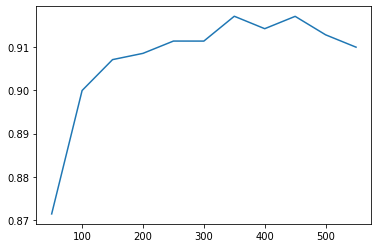

In [97]:
plt.plot(numOfFeatures, scores_log)

#### 8.4 CatBoost

In [98]:
params_cat = []
scores_cat = []
accuracies_cat = []

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

for num in numOfFeatures:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_tda[:, bestFeatures]

    cat = CatBoostClassifier(iterations=250);

    grid_search_result = cat.grid_search(grid, 
                                       X=X_train_tda, 
                                       y=y_train, 
                                       plot=True)

    params_cat.append(grid_search_result.params)
    scores_cat.append(grid_search_result.cv_results['train-error-mean'])

    X_test_num = X_test_tda[:, bestFeatures]
    best = CatBoostClassifier(iterations=250, grid_search_result.params);
    best.fit(X_train_best, y_train);
    accuracies_cat.append(best.score(X_test_num, y_test))

print("FINISHED")

50


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2920819	test: 2.2940782	best: 2.2940782 (0)	total: 513ms	remaining: 2m 7s
1:	learn: 2.2815160	test: 2.2852455	best: 2.2852455 (1)	total: 725ms	remaining: 1m 29s
2:	learn: 2.2731389	test: 2.2774098	best: 2.2774098 (2)	total: 942ms	remaining: 1m 17s
3:	learn: 2.2640713	test: 2.2699063	best: 2.2699063 (3)	total: 1.16s	remaining: 1m 11s
4:	learn: 2.2550766	test: 2.2616218	best: 2.2616218 (4)	total: 1.35s	remaining: 1m 6s
5:	learn: 2.2452952	test: 2.2526212	best: 2.2526212 (5)	total: 1.57s	remaining: 1m 3s
6:	learn: 2.2378188	test: 2.2453876	best: 2.2453876 (6)	total: 1.78s	remaining: 1m 1s
7:	learn: 2.2286248	test: 2.2372013	best: 2.2372013 (7)	total: 1.98s	remaining: 59.9s
8:	learn: 2.2181159	test: 2.2282455	best: 2.2282455 (8)	total: 2.15s	remaining: 57.7s
9:	learn: 2.2091755	test: 2.2199046	best: 2.2199046 (9)	total: 2.32s	remaining: 55.7s
10:	learn: 2.2001159	test: 2.2118564	best: 2.2118564 (10)	total: 2.5s	remaining: 54.2s
11:	learn: 2.1897728	test: 2.2034884	best: 2.20348

AttributeError: ignored

### 9 Adding new features


In [ ]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
    #images.DilationFiltration
    #images.ErosionFiltration
    #images.SignedDistanceFiltration
    #images.DensityFiltration
)

diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 1}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 1, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 1, "sigma": 3.2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 1.6, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.2, "n_bins": 100}},
    #NEW FEATURES
    {"metric": "persistence_image", "metric_params": {"p": 1}}, 
    {"metric": "persistence_image", "metric_params": {"p": 2}},
    {"metric": "silhouette", "metric_params": {"p": 1}},
    {"metric": "silhouette", "metric_params": {"p": 2}}
]

feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)] #add features
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

set_config(display='diagram')

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-14',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-15',
                                                                                 Amplitude(metric='persistence_image',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-16',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-17',
                                                                                 Amplitude(metric='silhouette',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1))]))]))])

In [ ]:
X_train_tda = tda_union.fit_transform(X_train)
X_test_tda = tda_union.transform(X_test)
X_train_tda.shape

(700, 612)

### 10. Train models without topological features

In [ ]:
X_train_notop = X_train.reshape(X_train.shape[0],-1)
X_test_notop = X_test.reshape(X_test.shape[0],-1)

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_notop, y_train)

rf.score(X_test_notop, y_test)

0.8933333333333333

Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_notop, y_train)

lr.score(X_test_notop, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8833333333333333

SVC

In [ ]:
model_linear = SVC(kernel='linear')
model_linear.fit(X_train_notop, y_train)

model_linear.score(X_test_notop, y_test)

0.8733333333333333

LightGBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_notop, y_train)

lgbm.score(X_test_notop, y_test)

0.8633333333333333

CatBoost

In [ ]:
cat = CatBoostClassifier(task_type="GPU",
                           devices='0:1')
cat.fit(X_train_notop, y_train, verbose=False)

cat.score(X_test_notop, y_test)

0.89

XGBT

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_notop, y_train)

xgb.score(X_test_notop, y_test)

0.8566666666666667

### 11 Grid Search for non-topological models

In [14]:
X_train_notop = X_train.reshape(X_train.shape[0],-1)
X_test_notop = X_test.reshape(X_test.shape[0],-1)

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train_notop, y_train)
sortedFeatures = rf.feature_importances_.argsort()

numOfFeatures_notop = np.arange(50, len(sortedFeatures), 50)

In [18]:
params_notop_svm = []
scores_notop_svm = []
accuracies_notop_svm = []

svm_params = {
    'kernel' : ('linear', 'sigmoid', 'rbf', 'poly'),
    'C' : [10 ** i for i in range(-2, 3)],
    'degree' : [3, 5, 7],
    'coef0' : [j**i for i in np.arange(-4,1,1) for j in np.arange(1.,4.,1.)],
    'gamma' : ('scale', 'auto'),
    'decision_function_shape': ('ovr', 'ovo')
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    svm = SVC(random_state=42)

    svm_grid = GridSearchCV(
        estimator=svm, param_grid=svm_params, cv=3, n_jobs=-1, verbose=4
    )

    svm_grid.fit(X_train_best, y_train)

    params_notop_svm.append(svm_grid.best_params_)
    scores_notop_svm.append(svm_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_svm.append(svm_grid.best_estimator_.score(X_test_num, y_test))

50
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
100
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
150
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
200
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
250
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
300
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
350
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
400
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
450
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
500
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
550
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
600
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
650
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
700
Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
750
Fitting 3 folds f

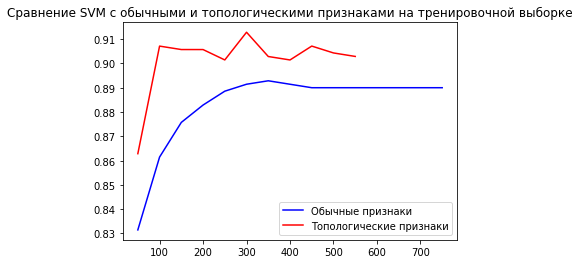

In [26]:
plt.plot(numOfFeatures_notop, scores_notop_svm, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_svm, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение SVM с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/svm_diff_features_train.png')
plt.show()

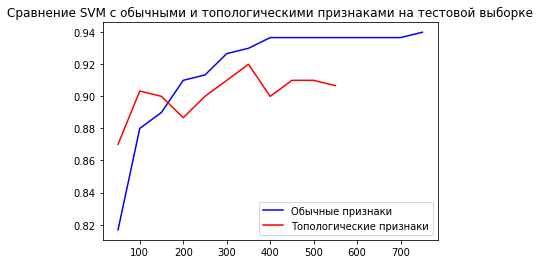

In [27]:
plt.plot(numOfFeatures_notop, accuracies_notop_svm, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_svm, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение SVM с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/svm_diff_features_test.png')
plt.show()

In [29]:
params_notop_rf = []
scores_notop_rf = []
accuracies_notop_rf = []

rf_params = {
    "n_estimators": [500, 1000],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    rf = RandomForestClassifier(random_state=42)

    rf_grid = GridSearchCV(
    estimator=rf, param_grid=rf_params, cv=3, n_jobs=-1, verbose=4
)

    rf_grid.fit(X_train_best, y_train)

    params_notop_rf.append(rf_grid.best_params_)
    scores_notop_rf.append(rf_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_rf.append(rf_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 243 candidates, totalling 729 fits
100
Fitting 3 folds for each of 243 candidates, totalling 729 fits
150
Fitting 3 folds for each of 243 candidates, totalling 729 fits
200
Fitting 3 folds for each of 243 candidates, totalling 729 fits
250
Fitting 3 folds for each of 243 candidates, totalling 729 fits
300
Fitting 3 folds for each of 243 candidates, totalling 729 fits
350
Fitting 3 folds for each of 243 candidates, totalling 729 fits
400
Fitting 3 folds for each of 243 candidates, totalling 729 fits
450
Fitting 3 folds for each of 243 candidates, totalling 729 fits
500
Fitting 3 folds for each of 243 candidates, totalling 729 fits
550
Fitting 3 folds for each of 243 candidates, totalling 729 fits
600
Fitting 3 folds for each of 243 candidates, totalling 729 fits
650
Fitting 3 folds for each of 243 candidates, totalling 729 fits
700
Fitting 3 folds for each of 243 candidates, totalling 729 fits
750
Fitting 3 folds for each of 243 candidates, totalling 729 f

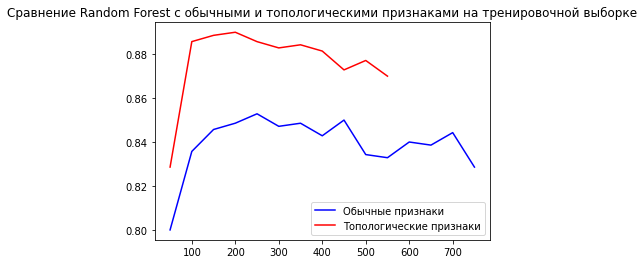

In [32]:
plt.plot(numOfFeatures_notop, scores_notop_rf, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_rf, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Random Forest с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/rf_diff_features_train.png')
plt.show()

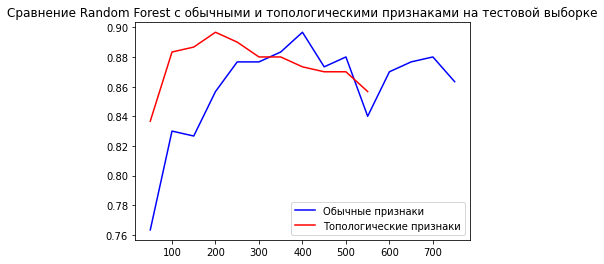

In [33]:
plt.plot(numOfFeatures_notop, accuracies_notop_rf, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_rf, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Random Forest с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/rf_diff_features_test.png')
plt.show()

In [34]:
params_notop_log = []
scores_notop_log = []
accuracies_notop_log = []


log_params = {
    "C" : np.logspace(-3,3,7), 
    "penalty" : ["l1","l2", "lasso"],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    log = LogisticRegression()

    log_grid = GridSearchCV(
        estimator=log, param_grid=log_params, cv=3, n_jobs=-1, verbose=4
    )

    log_grid.fit(X_train_best, y_train)

    params_notop_log.append(log_grid.best_params_)
    scores_notop_log.append(log_grid.best_score_)

    X_test_num = X_test_notop[:, bestFeatures]
    accuracies_notop_log.append(log_grid.best_estimator_.score(X_test_num, y_test))

print("FINISHED")

50
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.72568871        nan 0.7099764  0.70145385
 0.67863737 0.69575584 0.71431716 0.73003558        nan        nan
        nan        nan        nan        nan        nan 0.74143771
        nan 0.76144798 0.68432926 0.67435164 0.66861084 0.7085947
 0.72860497        nan        nan        nan        nan        nan
        nan        nan 0.6729088         nan 0.73432131 0.65580866
 0.66723524 0.66148222 0.70573958 0.7314662         nan        nan
        nan        nan        nan        nan        nan 0.64864947
        nan 0.7314662  0.65723317 0.66008828 0.66005771 0.70717019
 0.73146008        nan        nan        nan        nan        nan
        nan        nan 0.62435347        nan 0.73002947 0.6443882
 0.65865767 0.64290867 0.70715797 0.72718047        nan        nan
        nan        nan        n

100
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.76998887        nan 0.75856841 0.78000318
 0.77716029 0.71575389 0.78001541 0.77857868        nan        nan
        nan        nan        nan        nan        nan 0.77287456
        nan 0.80000122 0.77145006 0.76287248 0.68287419 0.77858479
 0.78285218        nan        nan        nan        nan        nan
        nan        nan 0.71858455        nan 0.79141753 0.76574594
 0.76430921 0.6742905  0.78286441 0.77857256        nan        nan
        nan        nan        nan        nan        nan 0.68286196
        nan 0.7828583  0.76859494 0.76575816 0.66858638 0.77716029
 0.7828583         nan        nan        nan        nan        nan
        nan        nan 0.68574765        nan 0.78000318 0.76287248
 0.76717655 0.66430676 0.77717252 0.78000318        nan        nan
        nan        nan       

150
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.78002152        nan 0.75282149 0.79856449
 0.78715625 0.73717032 0.79001749 0.7942971         nan        nan
        nan        nan        nan        nan        nan 0.76142352
        nan 0.80428695 0.7871318  0.78715625 0.71573554 0.79573383
 0.7928726         nan        nan        nan        nan        nan
        nan        nan 0.72281526        nan 0.79573383 0.78427668
 0.78144602 0.70858247 0.78715625 0.79287872        nan        nan
        nan        nan        nan        nan        nan 0.70710294
        nan 0.79430322 0.78287052 0.77572967 0.69572527 0.7928726
 0.79287872        nan        nan        nan        nan        nan
        nan        nan 0.73286013        nan 0.7900236  0.77715418
 0.77716029 0.69571916 0.78572564 0.79144199        nan        nan
        nan        nan        

200
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.77857868        nan 0.76139907 0.81429515
 0.79857672 0.77714195 0.80571146 0.81143392        nan        nan
        nan        nan        nan        nan        nan 0.77429906
        nan 0.81428292 0.80571757 0.79285426 0.76998276 0.8085788
 0.8100033         nan        nan        nan        nan        nan
        nan        nan 0.74716628        nan 0.81428292 0.80286245
 0.79142365 0.76569703 0.8085788  0.81285842        nan        nan
        nan        nan        nan        nan        nan 0.75141533
        nan 0.81143392 0.7871318  0.78857464 0.76569703 0.80856046
 0.81571965        nan        nan        nan        nan        nan
        nan        nan 0.77712361        nan 0.81428292 0.7857073
 0.78714403 0.76713376 0.80857269 0.81285842        nan        nan
        nan        nan        n

250
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.7828583         nan 0.76997053 0.81571965
 0.81284008 0.77428683 0.81284619 0.80999107        nan        nan
        nan        nan        nan        nan        nan 0.78288275
        nan 0.81143392 0.81571353 0.81284619 0.77285622 0.8128523
 0.81427069        nan        nan        nan        nan        nan
        nan        nan 0.76142964        nan 0.81140946 0.81285842
 0.81142169 0.77428683 0.80856046 0.81141558        nan        nan
        nan        nan        nan        nan        nan 0.77288067
        nan 0.80856046 0.80856046 0.80428084 0.77571133 0.81425846
 0.81141558        nan        nan        nan        nan        nan
        nan        nan 0.79144199        nan 0.81284008 0.80285023
 0.80284411 0.77714195 0.80856046 0.81284008        nan        nan
        nan        nan        

300
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79285426        nan 0.77425015 0.81569519
 0.80569923 0.79141753 0.81997481 0.81855031        nan        nan
        nan        nan        nan        nan        nan 0.79573995
        nan 0.81711969 0.81427681 0.80712373 0.78283995 0.81425235
 0.81997481        nan        nan        nan        nan        nan
        nan        nan 0.7700011         nan 0.81855031 0.81427681
 0.80428084 0.78142157 0.81713192 0.81568908        nan        nan
        nan        nan        nan        nan        nan 0.77287456
        nan 0.81711969 0.80571146 0.80285023 0.77857256 0.81140335
 0.81711969        nan        nan        nan        nan        nan
        nan        nan 0.79143587        nan 0.81855031 0.80141961
 0.80284411 0.77857256 0.81425846 0.81569519        nan        nan
        nan        nan       

350
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79857061        nan 0.76998276 0.82284216
 0.81142169 0.79710331 0.81998704 0.82427277        nan        nan
        nan        nan        nan        nan        nan 0.80857269
        nan 0.82427277 0.82284827 0.81428292 0.79853393 0.82141765
 0.82284827        nan        nan        nan        nan        nan
        nan        nan 0.79286037        nan 0.82569727 0.82427888
 0.81571965 0.79711554 0.82142377 0.82426666        nan        nan
        nan        nan        nan        nan        nan 0.78999914
        nan 0.82570339 0.81429515 0.81287065 0.79569104 0.81998704
 0.82141765        nan        nan        nan        nan        nan
        nan        nan 0.79857061        nan 0.82141765 0.81429515
 0.81715026 0.79711554 0.82284827 0.82141765        nan        nan
        nan        nan       

400
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79713999        nan 0.77140726 0.81856254
 0.81142169 0.80140738 0.81714415 0.81856254        nan        nan
        nan        nan        nan        nan        nan 0.80143184
        nan 0.82284216 0.81713804 0.80998496 0.802838   0.82283604
 0.81999315        nan        nan        nan        nan        nan
        nan        nan 0.79430933        nan 0.82142377 0.81571353
 0.80713596 0.79997677 0.82140543 0.81999315        nan        nan
        nan        nan        nan        nan        nan 0.81001553
        nan 0.82141765 0.80713596 0.80714207 0.79854615 0.82141765
 0.82142377        nan        nan        nan        nan        nan
        nan        nan 0.80426861        nan 0.81856254 0.80714207
 0.80571146 0.79854615 0.82139931 0.81998704        nan        nan
        nan        nan       

450
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79999511        nan 0.77140726 0.824285
 0.81284619 0.81426458 0.82141765 0.81999315        nan        nan
        nan        nan        nan        nan        nan 0.80142572
        nan 0.82284216 0.82142377 0.80999719 0.80712373 0.82426666
 0.81998704        nan        nan        nan        nan        nan
        nan        nan 0.80146241        nan 0.82426666 0.82284827
 0.80571757 0.80425639 0.82141765 0.81856254        nan        nan
        nan        nan        nan        nan        nan 0.80001345
        nan 0.82284827 0.80714818 0.80714818 0.80568089 0.81856254
 0.82284827        nan        nan        nan        nan        nan
        nan        nan 0.79855838        nan 0.82141765 0.80714818
 0.80714818 0.80568089 0.81855642 0.82141765        nan        nan
        nan        nan        n

500
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79857061        nan 0.77140726 0.82285438
 0.81570131 0.81855031 0.82427277 0.82284827        nan        nan
        nan        nan        nan        nan        nan 0.80714207
        nan 0.82427888 0.82285438 0.81284619 0.80997885 0.81855642
 0.82141765        nan        nan        nan        nan        nan
        nan        nan 0.8043053         nan 0.827134   0.81999927
 0.8114278  0.80996662 0.82141765 0.82427277        nan        nan
        nan        nan        nan        nan        nan 0.81285842
        nan 0.82570339 0.81143392 0.8114278  0.80854212 0.81856865
 0.82427277        nan        nan        nan        nan        nan
        nan        nan 0.799989          nan 0.82141765 0.8085788
 0.8085788  0.80854212 0.82571561 0.82427277        nan        nan
        nan        nan        

550
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79713999        nan 0.77140726 0.82285438
 0.81570131 0.81855031 0.8257095  0.82712789        nan        nan
        nan        nan        nan        nan        nan 0.80857269
        nan 0.82570339 0.81999315 0.81284619 0.80997885 0.81998704
 0.82426666        nan        nan        nan        nan        nan
        nan        nan 0.8043053         nan 0.82427277 0.81999315
 0.80999719 0.81139723 0.81998704 0.82427888        nan        nan
        nan        nan        nan        nan        nan 0.81000942
        nan 0.82569727 0.81143392 0.8114278  0.80711762 0.81713804
 0.82284216        nan        nan        nan        nan        nan
        nan        nan 0.79854004        nan 0.82284216 0.8100033
 0.8100033  0.80711762 0.824285   0.82570339        nan        nan
        nan        nan        

600
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79713999        nan 0.77140726 0.82285438
 0.81570131 0.81855031 0.82141154 0.82427277        nan        nan
        nan        nan        nan        nan        nan 0.80714818
        nan 0.82427277 0.81999315 0.81284619 0.81140335 0.81999315
 0.82427277        nan        nan        nan        nan        nan
        nan        nan 0.8043053         nan 0.829983   0.82142377
 0.80999719 0.81139723 0.82283604 0.82570339        nan        nan
        nan        nan        nan        nan        nan 0.80714207
        nan 0.82284827 0.81143392 0.8100033  0.80711762 0.81855642
 0.82141765        nan        nan        nan        nan        nan
        nan        nan 0.80427473        nan 0.82142377 0.81143392
 0.8085788  0.80711762 0.81856865 0.82427888        nan        nan
        nan        nan       

650
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79427876        nan 0.76998276 0.82142377
 0.81570131 0.81855031 0.81856865 0.82570339        nan        nan
        nan        nan        nan        nan        nan 0.8085788
        nan 0.82427277 0.81999315 0.81284619 0.80997885 0.81998704
 0.82570339        nan        nan        nan        nan        nan
        nan        nan 0.80144407        nan 0.8285585  0.82142377
 0.8128523  0.80997273 0.81570131 0.82284827        nan        nan
        nan        nan        nan        nan        nan 0.80858491
        nan 0.82284216 0.81428292 0.8114278  0.80711762 0.82142988
 0.82570339        nan        nan        nan        nan        nan
        nan        nan 0.79714611        nan 0.82569727 0.8114278
 0.8085788  0.80711762 0.82284827 0.82284827        nan        nan
        nan        nan        n

700
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79713999        nan 0.77140726 0.82285438
 0.81570131 0.81855031 0.81856865 0.82141765        nan        nan
        nan        nan        nan        nan        nan 0.80714818
        nan 0.82570339 0.81999315 0.81284619 0.80998496 0.82426666
 0.82284827        nan        nan        nan        nan        nan
        nan        nan 0.80144407        nan 0.827134   0.81856254
 0.8128523  0.80711762 0.81998093 0.82284827        nan        nan
        nan        nan        nan        nan        nan 0.80287468
        nan 0.82712789 0.81428292 0.8114278  0.80711762 0.81856254
 0.82427277        nan        nan        nan        nan        nan
        nan        nan 0.79998288        nan 0.82283604 0.8114278
 0.8100033  0.80711762 0.81713192 0.82570339        nan        nan
        nan        nan        

750
Fitting 3 folds for each of 105 candidates, totalling 315 fits


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79999511        nan 0.77140726 0.82142377
 0.81427681 0.81855031 0.81998704 0.82427277        nan        nan
        nan        nan        nan        nan        nan 0.80571757
        nan 0.82427277 0.81999315 0.81141558 0.81427069 0.82427277
 0.82283604        nan        nan        nan        nan        nan
        nan        nan 0.80287468        nan 0.82712789 0.81570742
 0.8128523  0.80854823 0.81857476 0.82569727        nan        nan
        nan        nan        nan        nan        nan 0.80859103
        nan 0.827134   0.8128523  0.8114278  0.80569311 0.82284216
 0.82427277        nan        nan        nan        nan        nan
        nan        nan 0.80142572        nan 0.82426666 0.80999719
 0.8100033  0.80711762 0.81856254 0.82284827        nan        nan
        nan        nan       

FINISHED


/home/snopoff/miniconda3/envs/topology/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


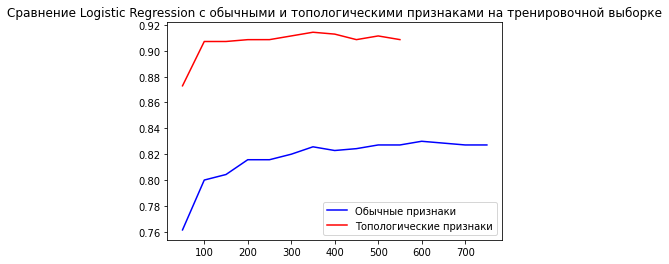

In [35]:
plt.plot(numOfFeatures_notop, scores_notop_log, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_log, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Logistic Regression с обычными и топологическими признаками на тренировочной выборке")
plt.savefig('images/log_diff_features_train.png')
plt.show()

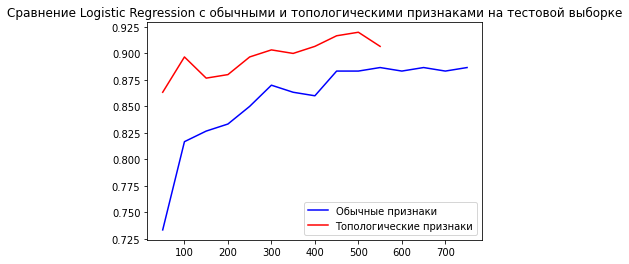

In [36]:
plt.plot(numOfFeatures_notop, accuracies_notop_log, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_log, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение Logistic Regression с обычными и топологическими признаками на тестовой выборке")
plt.savefig('images/log_diff_features_test.png')
plt.show()

In [ ]:
params_notop_cat = []
scores_notop_cat = []
accuracies_notop_cat = []

grid = {'learning_rate': [0.003, 0.03],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [0.03, 0.1, 1]}

for num in numOfFeatures_notop:
    print(num)
    bestFeatures = sortedFeatures[-num:][::-1]
    X_train_best = X_train_notop[:, bestFeatures]

    cat = CatBoostClassifier(iterations=250);

    grid_search_result = cat.grid_search(grid, 
                                       X=X_train_best, 
                                       y=y_train, 
                                       plot=True)

    #grid_search_result.fit(X_train_best, y_train)

    params_notop_cat.append(grid_search_result.params)
    scores_notop_cat.append(grid_search_result.cv_results['train-error-mean'])

    X_test_num = X_test_notop[:, bestFeatures]
    best = CatBoostClassifier(iterations=250, grid_search_result.params);
    best.fit(X_train_best, y_train);
    accuracies_notop_cat.append(best.score(X_test_num, y_test))

print("FINISHED")

In [ ]:
plt.plot(numOfFeatures_notop, scores_notop_cat, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, scores_cat, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение CatBoost с обычными и топологическими признаками на тренировочной выборке")

In [ ]:
plt.plot(numOfFeatures_notop, accuracies_notop_cat, "-b", label="Обычные признаки")
plt.plot(numOfFeatures, accuracies_cat, "-r", label="Топологические признаки")
plt.legend(loc='best')
plt.title("Сравнение CatBoost с обычными и топологическими признаками на тестовой выборке")

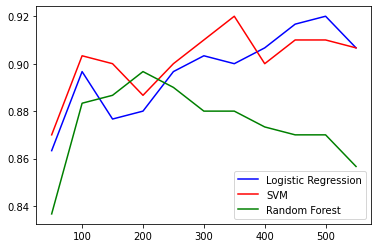

In [37]:
plt.plot(numOfFeatures, accuracies_log, "-b", label="Logistic Regression")
plt.plot(numOfFeatures, accuracies_svm, "-r", label="SVM")
plt.plot(numOfFeatures, accuracies_rf, "-g", label="Random Forest")
plt.legend(loc='best')
#plt.title("Сравнение CatBoost с обычными и топологическими признаками на тестовой выборке")
plt.savefig("images/models-topfeatures.png")
plt.show()

In [43]:
best_svm_model = SVC(random_state=42, **params_svm[6])

In [48]:
pearsonr(X_train_tda, y_train)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [53]:
import pandas as pd
data = pd.DataFrame(X_train_tda)
corr = data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [59]:
data_test = pd.DataFrame(X_test_tda)
data_test = data_test[selected_columns]

In [60]:
data_test.shape

(300, 51)

In [55]:
best_svm_model.fit(data, y_train)

SVC(C=10, coef0=1.0, degree=5, gamma='auto', kernel='poly', random_state=42)

In [61]:
best_svm_model.score(data_test, y_test)

0.83

In [103]:
best_svm_model = SVC(random_state=42, **params_svm[6])
best_svm_model.fit(X_train_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]], y_train)

SVC(C=10, coef0=1.0, degree=5, gamma='auto', kernel='poly', random_state=42)

In [104]:
best_svm_model.score(X_test_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]], y_test)

0.89

In [105]:
y_hat = best_svm_model.predict(X_test_tda[:,sortedFeatures[-numOfFeatures[6]:][::-1]])

In [106]:
mismatches = np.where((y_hat == y_test) == False)[0]

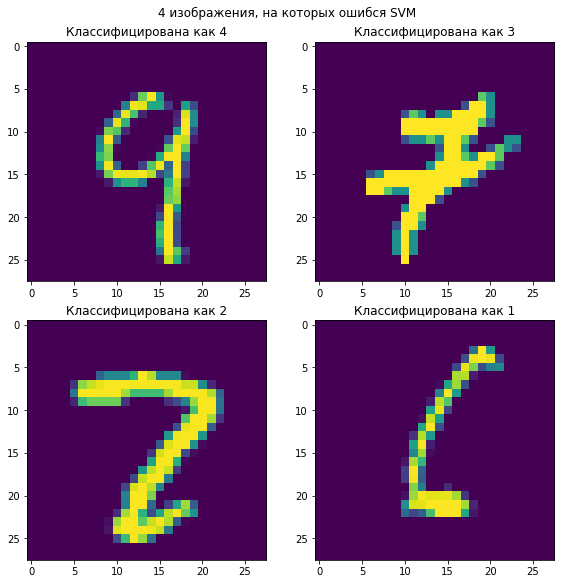

In [115]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8), constrained_layout=True)
for i in range(4):
    ax = axes.flat[i]
    ind = mismatches[i+4]
    ax.imshow(X_test[ind])
    ax.title.set_text("Классифицирована как {}".format(y_hat[ind]))
fig.suptitle("4 изображения, на которых ошибся SVM")
plt.savefig("images/missclassified.png")
plt.show()
